In [142]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction import stop_words
from sklearn.metrics import f1_score
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline


In [129]:
data = pd.read_csv('train.csv', index_col = 0)
pd.set_option('max_colwidth', 140)
data.head()

,question_text,target
qid,,
00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [23]:
data.target.value_counts()[1]/data.target.value_counts().sum()

0.06187017751787352

In [130]:
data_small = data.sample(100000, replace = False)
data_small.target.value_counts()[1]/data_small.target.value_counts().sum()

0.062609999999999999

In [28]:
X = data_small['question_text']
Y = data_small['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)

In [109]:
def model_vectorize(vectorizer_type, binary_type, ngram, stop_word, model_type):
    vectorizer = vectorizer_type(binary = binary_type, stop_words = stop_word, ngram_range=ngram)
    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    model = model_type
    model.fit(X_train_vectorized, Y_train)

    
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_vectorized)[:,1])
    auc = metrics.auc(fpr, tpr)
    
    tn, fp, fn, tp = confusion_matrix(Y_test, model.predict(X_test_vectorized)).ravel()

    f_score = 2*tp/(2*tp + fp + fn)
    f1_score = metrics.f1_score(Y_test, model.predict(X_test_vectorized))
    
    return(fpr, tpr, auc, f_score, f1_score)

In [66]:
#create models
vectorizer_type = [CountVectorizer, TfidfVectorizer]
binary_type = [True, False]
ngram = [(1,2), (1,3), (1,4)]
model_type = [LogisticRegression(), BernoulliNB()]

model_initialize = []
for i in vectorizer_type:
    for j in binary_type:
        for k in ngram:
            for l in model_type:
                model_initialize.append(model_vectorize(i, j, k, l))

In [77]:
#create labels
vectorizer_type_label = ['CountV', 'TFIDV']
binary_type_label = ['T', 'F']
ngram_label = [(1,2), (1,3), (1,4)]
model_type_label = ['LR', 'BNB']

labels = []
for i in vectorizer_type_label:
    for j in binary_type_label:
        for k in ngram_label:
            for l in model_type_label:
                label = '%s %s %s %s' %(i, j, k, l)
                labels.append(label)

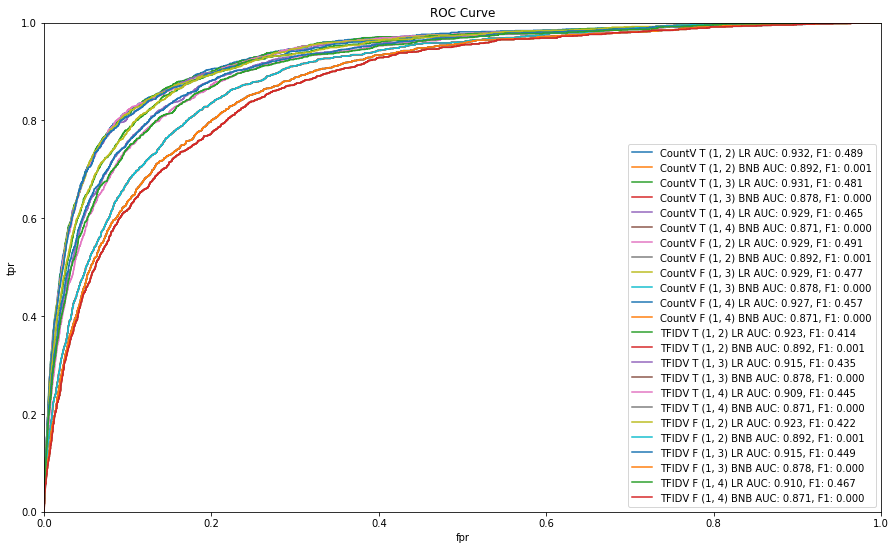

In [79]:
#graph the model

plt.rcParams['figure.figsize'] = 15, 9

ax = plt.subplot()
for i in range(len(model_initialize)):
    plt.plot(model_initialize[i][0], model_initialize[i][1], 
             label = labels[i] + ' AUC: %.3f, F1: %.3f' %(model_initialize[i][2], model_initialize[i][3]))

    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

In [99]:
fscores = []
aucs = []
for i in range(len(model_initialize)):
    aucs.append(model_initialize[i][2])
    fscores.append(model_initialize[i][3])
metrics = pd.DataFrame({'label': labels, 'auc': aucs, 'fscore': fscores})
metrics.sort_values(by = ['fscore'], ascending=False)

,auc,fscore,label
6,0.929202,0.490822,"CountV F (1, 2) LR"
0,0.931641,0.488673,"CountV T (1, 2) LR"
2,0.930656,0.480960,"CountV T (1, 3) LR"
8,0.928631,0.476860,"CountV F (1, 3) LR"
22,0.909985,0.467013,"TFIDV F (1, 4) LR"
4,0.928614,0.465254,"CountV T (1, 4) LR"
10,0.926802,0.456540,"CountV F (1, 4) LR"
20,0.915119,0.448606,"TFIDV F (1, 3) LR"
16,0.909271,0.444530,"TFIDV T (1, 4) LR"
14,0.914548,0.434889,"TFIDV T (1, 3) LR"


In [102]:
stop = stop_words.ENGLISH_STOP_WORDS

In [104]:
#create models
vectorizer_type = [CountVectorizer, TfidfVectorizer]
binary_type = [True, False]
ngram = [(1,2), (1,3), (1,4)]
stop_word = [None, stop]
model_type = [LogisticRegression(), BernoulliNB()]

model_initialize = []
for i in vectorizer_type:
    for j in binary_type:
        for k in ngram:
            for l in model_type:
                for m in stop_word:
                    model_initialize.append(model_vectorize(i, j, k, m, l))

In [105]:
#create labels
vectorizer_type_label = ['CountV', 'TFIDV']
binary_type_label = ['T', 'F']
ngram_label = [(1,2), (1,3), (1,4)]
stop_word_label = ['None', 'english']
model_type_label = ['LR', 'BNB']

labels = []
for i in vectorizer_type_label:
    for j in binary_type_label:
        for k in ngram_label:
            for l in model_type_label:
                for m in stop_word_label:
                    label = '%s %s %s %s %s' %(i, j, k, m, l)
                    labels.append(label)

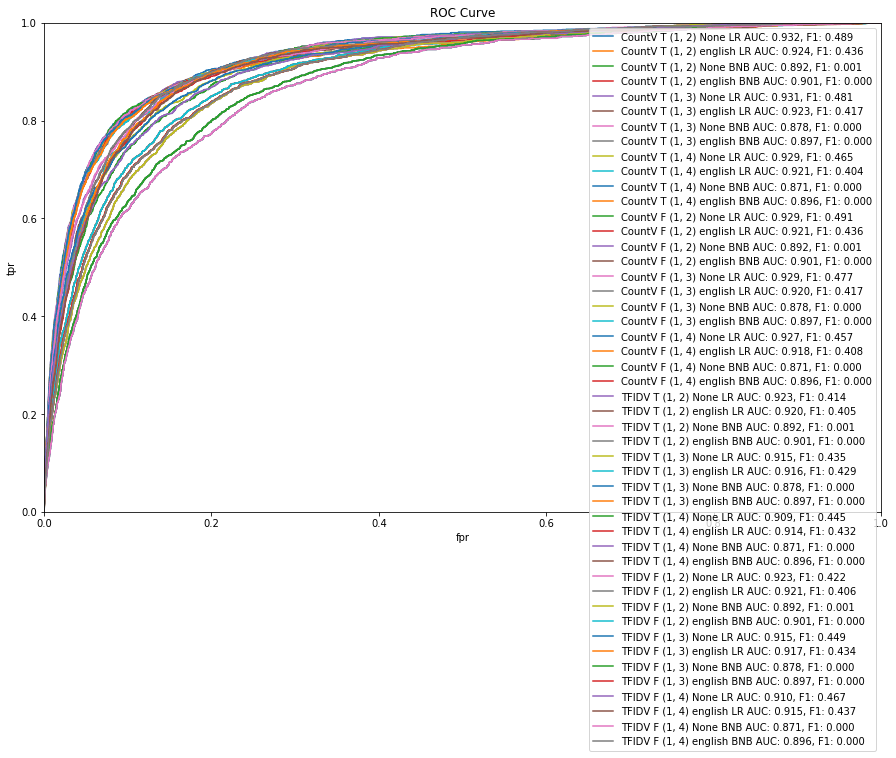

In [106]:
#graph the model

plt.rcParams['figure.figsize'] = 15, 9

ax = plt.subplot()
for i in range(len(model_initialize)):
    plt.plot(model_initialize[i][0], model_initialize[i][1], 
             label = labels[i] + ' AUC: %.3f, F1: %.3f' %(model_initialize[i][2], model_initialize[i][3]))

    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

In [107]:
fscores = []
aucs = []
for i in range(len(model_initialize)):
    aucs.append(model_initialize[i][2])
    fscores.append(model_initialize[i][3])
metrics = pd.DataFrame({'label': labels, 'auc': aucs, 'fscore': fscores})
metrics.sort_values(by = ['fscore'], ascending=False)

,auc,fscore,label
12,0.929202,0.490822,"CountV F (1, 2) None LR"
0,0.931641,0.488673,"CountV T (1, 2) None LR"
4,0.930656,0.480960,"CountV T (1, 3) None LR"
16,0.928631,0.476860,"CountV F (1, 3) None LR"
44,0.909985,0.467013,"TFIDV F (1, 4) None LR"
8,0.928614,0.465254,"CountV T (1, 4) None LR"
20,0.926802,0.456540,"CountV F (1, 4) None LR"
40,0.915119,0.448606,"TFIDV F (1, 3) None LR"
32,0.909271,0.444530,"TFIDV T (1, 4) None LR"
45,0.914574,0.437402,"TFIDV F (1, 4) english LR"


In [110]:
#create models
vectorizer_type = [CountVectorizer, TfidfVectorizer]
binary_type = [True, False]
ngram = [(1,2), (1,3), (1,4)]
stop_word = [None, stop]
model_type = [LogisticRegression(), BernoulliNB()]

model_initialize = []
for i in vectorizer_type:
    for j in binary_type:
        for k in ngram:
            for l in model_type:
                for m in stop_word:
                    model_initialize.append(model_vectorize(i, j, k, m, l))

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
#create labels
vectorizer_type_label = ['CountV', 'TFIDV']
binary_type_label = ['T', 'F']
ngram_label = [(1,2), (1,3), (1,4)]
stop_word_label = ['None', 'english']
model_type_label = ['LR', 'BNB']

labels = []
for i in vectorizer_type_label:
    for j in binary_type_label:
        for k in ngram_label:
            for l in model_type_label:
                for m in stop_word_label:
                    label = '%s %s %s %s %s' %(i, j, k, m, l)
                    labels.append(label)

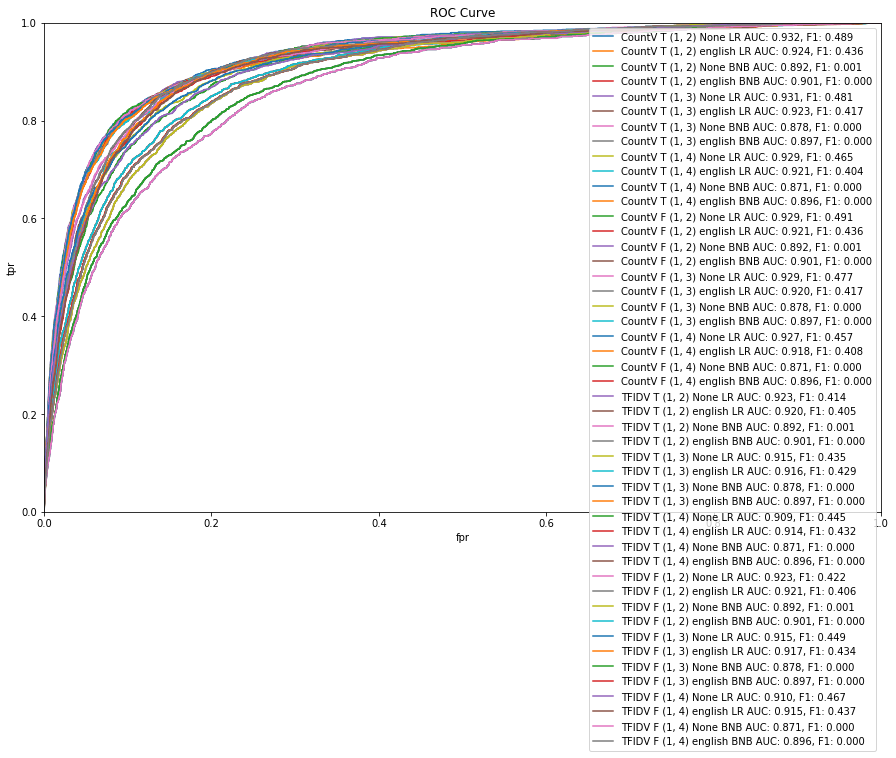

In [112]:
#graph the model

plt.rcParams['figure.figsize'] = 15, 9

ax = plt.subplot()
for i in range(len(model_initialize)):
    plt.plot(model_initialize[i][0], model_initialize[i][1], 
             label = labels[i] + ' AUC: %.3f, F1: %.3f' %(model_initialize[i][2], model_initialize[i][3]))

    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

In [114]:
f1_scores = []
fscores = []
aucs = []
for i in range(len(model_initialize)):
    aucs.append(model_initialize[i][2])
    fscores.append(model_initialize[i][3])
    f1_scores.append(model_initialize[i][4])
metrics = pd.DataFrame({'label': labels, 'auc': aucs, 'fscore': fscores, 'f_1': f1_scores})
metrics.sort_values(by = ['fscore'], ascending=False)

,auc,f_1,fscore,label
12,0.929202,0.490822,0.490822,"CountV F (1, 2) None LR"
0,0.931641,0.488673,0.488673,"CountV T (1, 2) None LR"
4,0.930656,0.480960,0.480960,"CountV T (1, 3) None LR"
16,0.928631,0.476860,0.476860,"CountV F (1, 3) None LR"
44,0.909985,0.467013,0.467013,"TFIDV F (1, 4) None LR"
8,0.928614,0.465254,0.465254,"CountV T (1, 4) None LR"
20,0.926802,0.456540,0.456540,"CountV F (1, 4) None LR"
40,0.915119,0.448606,0.448606,"TFIDV F (1, 3) None LR"
32,0.909271,0.444530,0.444530,"TFIDV T (1, 4) None LR"
45,0.914574,0.437402,0.437402,"TFIDV F (1, 4) english LR"


In [131]:
stemmer = SnowballStemmer('english')
data_small_stemmed = data_small.copy()
data_small_stemmed['question_text'] = [' '.join([stemmer.stem(word) for word in text.split(' ')])
          for text in data_small_stemmed.question_text]


In [132]:
data_small.head()

,question_text,target
qid,,
e5361a84e4b061003471,How do you pass an online test that does not give you your incorrect answers quickly?,0
da01da22badcd82ee5d6,Why do many intellectuals support socialism?,0
50811854476a64e6c40f,Why are organisations across the world in every country which are violent are mostly or all Islamic?,1
4a1f22750750bb3d6a66,What is the origin of the surname Catipay?,0
837b9854f90bb0e2bee8,What are the best paying jobs that require minimal work?,0


In [133]:
data_small_stemmed.head()

,question_text,target
qid,,
e5361a84e4b061003471,how do you pass an onlin test that doe not give you your incorrect answer quickly?,0
da01da22badcd82ee5d6,whi do mani intellectu support socialism?,0
50811854476a64e6c40f,whi are organis across the world in everi countri which are violent are most or all islamic?,1
4a1f22750750bb3d6a66,what is the origin of the surnam catipay?,0
837b9854f90bb0e2bee8,what are the best pay job that requir minim work?,0


In [135]:
X = data_small_stemmed['question_text']
Y = data_small_stemmed['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)

In [136]:
#create models
vectorizer_type = [CountVectorizer, TfidfVectorizer]
binary_type = [True, False]
ngram = [(1,2), (1,3), (1,4)]
stop_word = [None, stop]
model_type = [LogisticRegression()]

model_initialize = []
for i in vectorizer_type:
    for j in binary_type:
        for k in ngram:
            for l in model_type:
                for m in stop_word:
                    model_initialize.append(model_vectorize(i, j, k, m, l))

In [137]:
#create labels
vectorizer_type_label = ['CountV', 'TFIDV']
binary_type_label = ['T', 'F']
ngram_label = [(1,2), (1,3), (1,4)]
stop_word_label = ['None', 'english']
model_type_label = ['LR']

labels = []
for i in vectorizer_type_label:
    for j in binary_type_label:
        for k in ngram_label:
            for l in model_type_label:
                for m in stop_word_label:
                    label = '%s %s %s %s %s' %(i, j, k, m, l)
                    labels.append(label)

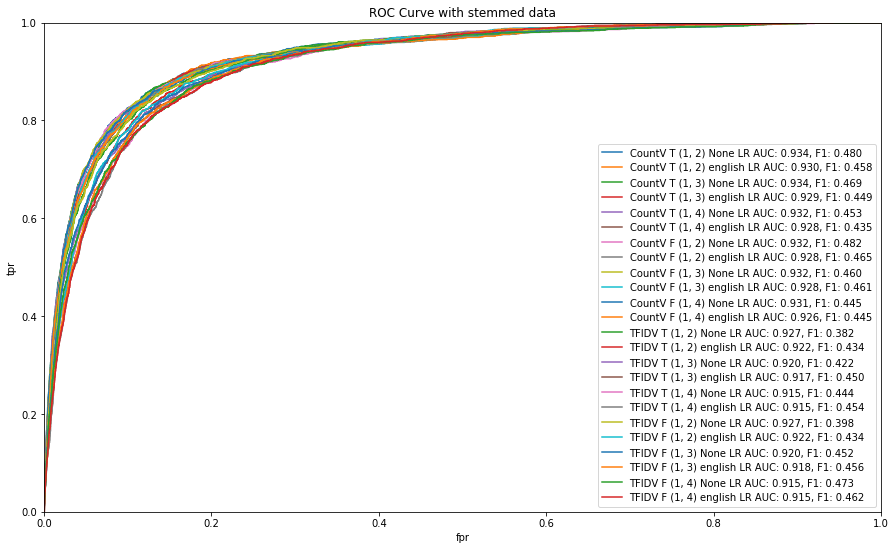

In [138]:
#graph the model

plt.rcParams['figure.figsize'] = 15, 9

ax = plt.subplot()
for i in range(len(model_initialize)):
    plt.plot(model_initialize[i][0], model_initialize[i][1], 
             label = labels[i] + ' AUC: %.3f, F1: %.3f' %(model_initialize[i][2], model_initialize[i][3]))

    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve with stemmed data")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

In [139]:
f1_scores = []
fscores = []
aucs = []
for i in range(len(model_initialize)):
    aucs.append(model_initialize[i][2])
    fscores.append(model_initialize[i][3])
    f1_scores.append(model_initialize[i][4])
metrics = pd.DataFrame({'label': labels, 'auc': aucs, 'fscore': fscores, 'f_1': f1_scores})
metrics.sort_values(by = ['fscore'], ascending=False)

,auc,f_1,fscore,label
6,0.931644,0.482387,0.482387,"CountV F (1, 2) None LR"
0,0.933625,0.480033,0.480033,"CountV T (1, 2) None LR"
22,0.915226,0.473323,0.473323,"TFIDV F (1, 4) None LR"
2,0.933555,0.469072,0.469072,"CountV T (1, 3) None LR"
7,0.928208,0.465488,0.465488,"CountV F (1, 2) english LR"
23,0.915216,0.461704,0.461704,"TFIDV F (1, 4) english LR"
9,0.927710,0.460616,0.460616,"CountV F (1, 3) english LR"
8,0.932035,0.460026,0.460026,"CountV F (1, 3) None LR"
1,0.929812,0.457821,0.457821,"CountV T (1, 2) english LR"
21,0.917727,0.455932,0.455932,"TFIDV F (1, 3) english LR"


In [145]:
X = data_small_stemmed['question_text']
Y = data_small_stemmed['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)

In [146]:
vectorizer = CountVectorizer(binary = False, ngram_range=(1,2))
vectorizer.fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
model = LogisticRegression()
model.fit(X_train_vectorized, Y_train)


fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_vectorized)[:,1])
auc = metrics.auc(fpr, tpr)

tn, fp, fn, tp = confusion_matrix(Y_test, model.predict(X_test_vectorized)).ravel()

f_score = 2*tp/(2*tp + fp + fn)
f1_score = metrics.f1_score(Y_test, model.predict(X_test_vectorized))
print('auc' , auc ,  'f' , f_score , 'f' , f1_score)

auc 0.928855992662 f 0.499161073826 f 0.499161073826


In [147]:
def data_prep(dataset):
    X = dataset['question_text']
    Y = dataset['target']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75)
    return(X_train, X_test, Y_train, Y_test)

In [148]:
vectorizer = CountVectorizer(binary = False, ngram_range=(1,2))
vectorizer.fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
model = LogisticRegression()
model.fit(X_train_vectorized, Y_train)


fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_vectorized)[:,1])
auc = metrics.auc(fpr, tpr)

tn, fp, fn, tp = confusion_matrix(Y_test, model.predict(X_test_vectorized)).ravel()

f_score = 2*tp/(2*tp + fp + fn)
f1_score = metrics.f1_score(Y_test, model.predict(X_test_vectorized))
print('auc' , auc ,  'f' , f_score , 'f' , f1_score)

auc 0.949616657581 f 0.575690219934 f 0.575690219934


In [151]:
def data_prep(dataset, training_split):
    X = dataset['question_text']
    Y = dataset['target']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = training_split)
    return(X_train, X_test, Y_train, Y_test)

#data_used = data_prep(dataset, training_split)

def model_vectorize(data_used, vectorizer_type, binary_type, ngram, stop_word, model_type):
    X_train = data_used[0]
    X_test = data_used[1]
    Y_train = data_used[2]
    Y_test = data_used[3]
    
    vectorizer = vectorizer_type(binary = binary_type, stop_words = stop_word, ngram_range=ngram)
    vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    model = model_type
    model.fit(X_train_vectorized, Y_train)

    fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_vectorized)[:,1])
    auc = metrics.auc(fpr, tpr)
    
    tn, fp, fn, tp = confusion_matrix(Y_test, model.predict(X_test_vectorized)).ravel()

    f_score = 2*tp/(2*tp + fp + fn)
    f1_score = metrics.f1_score(Y_test, model.predict(X_test_vectorized))
    
    return(fpr, tpr, auc, f_score, f1_score)

In [153]:
data_full_split = data_prep(data, 0.75)
best_small = model_vectorize(data_full_split, CountVectorizer, False, (1,2), None, LogisticRegression())

In [154]:
best_small[4]

0.58224112490235225